In [ ]:
#TODO
# 1.詢問助教是否是使用新的trainingdata和新的testingdata，如果是那就要做完善的洗資料，因為testingdata中就有一筆資料是有缺失的(blank)
# 2.詢問是否要用儲存成一個model，然後去跑助教的testingdata，並且在20天內得到最高的profit
# 3.重新判斷和確認high,low和close收盤價的關係
# 4.改模型參數LSTM 256->64， batch_size, learning_rate, epochs, train_test_split_ratio, past_day&future_day交叉測試
# 5.跑requirement.txt
# 6.跑Pipfile
# 7.寫Readme
# 8.ipynb -> py 整合，execute arguments defined
# 9.TestingCorrector是三小

#TOFIX
# 1.每次讀到csv的時候，第一個資料都會被miss掉，去找出原因 
    # Fixed: 只要在read_csv裡面加入header=None就會讓api自動忽略把第一筆資料當做column項了
# 2.把缺失的資料，用predata 和 postdata 的平均補上。目前是直接使用前一筆data

In [ ]:
!nvidia-smi

Tue Apr  6 15:52:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from statistics import mean
import csv

In [ ]:
# 以收盤價為train, 以開盤價為target label
def split_dataset(df, past_day, future_day):
  X, Y = [], []
  for i in range(len(df) - future_day - past_day):
    X.append(np.array(df[i:i+past_day, 0]))
    Y.append(np.array(df[i+past_day:i+past_day+future_day, 0]))
  return np.array(X), np.array(Y)



# print(x_train[0])
# print(y_train[0])
# print(x_train[1])
# print(y_train[1])
# print(x_train[2])
# print(y_train[2])

In [ ]:
def build_model(shape):
  model = Sequential()
  model.add(LSTM(64, input_shape=(shape[1], shape[2]), return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(64, return_sequences=True))
  model.add(Dropout(0.2))
  # model.add(LSTM(256, return_sequences=True))
  # model.add(Dropout(0.2))
  # model.add(LSTM(256, return_sequences=True))
  # model.add(Dropout(0.2))

  # model.add(TimeDistributed(Dense(1)))
  # model.add(Flatten())
  # model.add(Dense(5, activation='linear'))
  model.add(Dense(1))
  return model 

In [ ]:
def generate_csv():
  try:
    with open('output.csv', mode='w') as csv_file:
      writer = csv.writer(csv_file)
      writer.writerow([0])
      writer.writerow([-1])
      writer.writerow([1])
      csv_file.seek(0, os.SEEK_END)
      csv_file.truncate()
  except:
    raise

generate_csv()

In [ ]:
main_path = 'drive/My Drive/Colab Notebooks/DSAI_HW2'
print(os.listdir(main_path))

['training.csv', 'testing.csv']


In [ ]:
train_df = pd.read_csv(os.path.join(main_path, 'training.csv'), header=None)
test_df = pd.read_csv(os.path.join(main_path, 'testing.csv'), header=None)

train_df.drop([1,2,3], inplace=True, axis=1)
test_df.drop([1,2,3], inplace=True, axis=1)

'''
# Replace Nan Values with prevalues and postvalues mean
rows_with_nan = [index for index, row in test_df.iterrows() if row.isnull().any()]
print('------Before------')
print(test_df.iloc[rows_with_nan])

# print(test_df[0][rows_with_nan[0]-1])
# print(test_df[0][rows_with_nan[0]+1])
for row in range(len(rows_with_nan)):  #actually only have 1 row data got Nan values
  for col in test_df.columns:
    if test_df[col].isnull().any(): #figure out which column got Nan
      try:
        test_df[col].replace(test_df[0][rows_with_nan[0]-1] , inplace=True)
      except:
        print('Predata or Postdata is not available, please check again!')
        raise
    else:
      print('xxx')
  # print(test_df[3][rows_with_nan])
  # test_df[0].fillna(0, inplace=True)

print('------After------')
'''
test_df.fillna(method='ffill', inplace=True)
# print(test_df.iloc[rows_with_nan])
# print(test_df.isnull().any().sum())

# Scaling
sc = MinMaxScaler(feature_range=(-1, 1))
scaled_train_df = sc.fit_transform(train_df)
scaled_test_df  = sc.transform(test_df)

# Generate training data and label
x_train, y_train = split_dataset(scaled_train_df, past_day, future_day)
x_test, y_test = split_dataset(scaled_test_df, past_day, future_day)

In [ ]:
# Arguments
epochs = 100
batch_size = 32
past_day = 7
future_day = 1

In [ ]:
# Reshape the data into (Samples, Timestep, Features)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# Build model
model = build_model(x_train.shape)
model.summary()

# Compile and Fit
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1, mode='auto')
model.compile(optimizer=Adam(), loss='mean_squared_error')
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(x_test, y_test), shuffle=False, callbacks=[reduce_lr, early_stopping])
model.save('model.h5')


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 7, 64)             16896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 64)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 7, 64)             33024     
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 64)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 7, 1)              65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
40/40 [==============================] - 4s 29ms/step - loss: 0.2241 - val_loss: 0.0375
Epoch 2/100
40/4

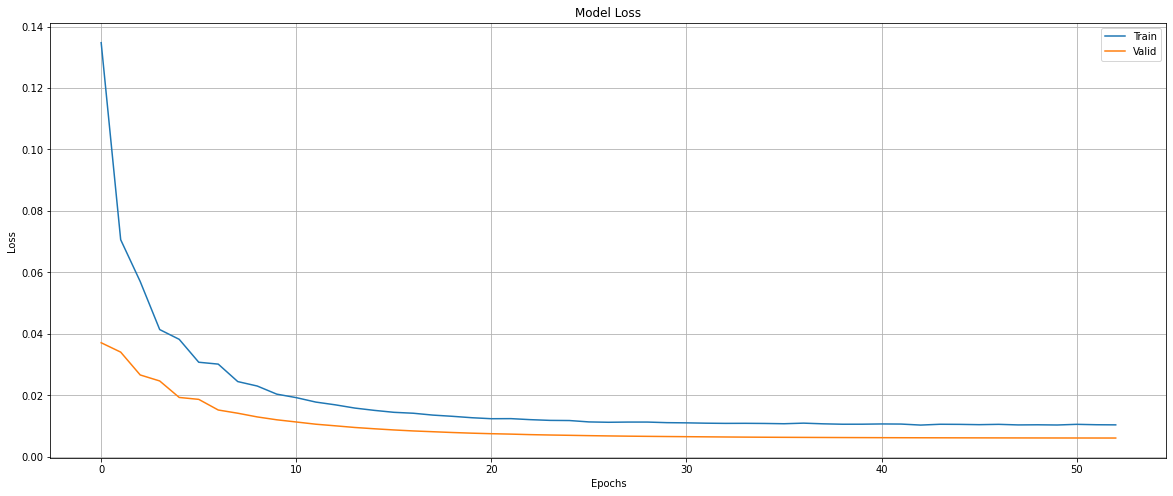

In [ ]:
# Plotting
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Valid'])
plt.grid(True)

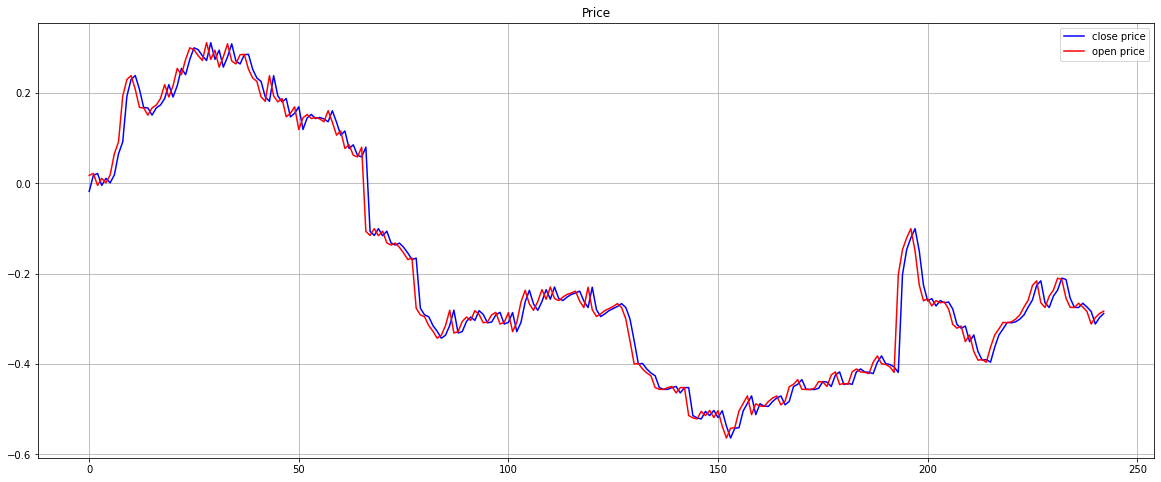

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(x_test[:,6,0], color='blue')
plt.plot(y_test, color='red')
plt.title("Price")
plt.grid(True)
plt.legend(['close price','open price'])

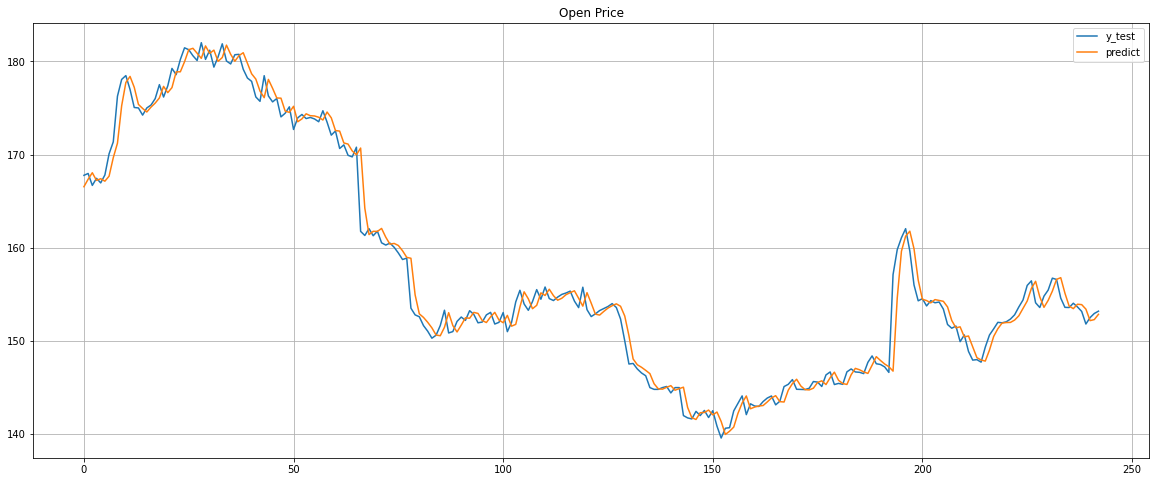

In [ ]:
predicted = model.predict(x_test)

predict = sc.inverse_transform(predicted.reshape(predicted.shape[0], predicted.shape[1]))
ground_truth = sc.inverse_transform(y_test.reshape(-1,1))
plt.figure(figsize=(20,8))
plt.plot(ground_truth)
plt.plot(predict[:,-1])
plt.title('Open Price')
plt.legend(['y_test','predict'])
plt.grid(True)